Evaluation of the user 

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import textwrap
import scipy.stats as stats

### Data Loading & Pre-Processing

In [4]:
df = pd.read_csv(os.path.join('data', 'MT_Resource-Analytics_4+August+2025_19.50.csv'))
df.drop(df[df['Finished'] == 'False'].index, inplace=True)

number_participants = len(df)-2

In [5]:
# replace all "strongly" agree by 7 in column U1 -> U12
for col in [f"U{i}" for i in range(1, 13)]:
    df[col] = df[col].replace("Strongly agree", 7)

## Feature Usage Analysis

1. Step: create a dataframe which holds the usage of features per question

In [6]:
feature_columns = ['Q34', 'Q35', 'Q36', 'Q37', 'Q38', 'Q39', 'Q40', 'Q41', 'Q42']
task_numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9]

task_list = []
feature_list = []
response_id_list = []

for index, row in df.iterrows():
    #skip the the two header rows
    if index < 2:
        continue
    
    #iterate through the defined feature columns holding
    for i, col in enumerate(feature_columns):
        task_num = task_numbers[i]
        features_text = row[col]
        response_id = row['ResponseId']
        
        #skip if no value is specified
        if pd.isna(features_text) or features_text == '':
            continue

        #split by comma if multiple features were specified
        if isinstance(features_text, str):
            features = [f.strip() for f in features_text.split(',')]
            
            #create new row with task number holding one feature
            for feature in features:
                if feature:
                    task_list.append(task_num)
                    feature_list.append(feature)
                    response_id_list.append(response_id)

#turn lists into dataframe and sort by task number
feature_usage_df = pd.DataFrame({
    'Task': task_list,
    'Feature': feature_list,
    'ResponseId': response_id_list
}).sort_values('Task').reset_index(drop=True)

print("Feature Usage Dataframe:")
print(feature_usage_df.head(20))
print(f"\nTotal rows: {len(feature_usage_df)}")
print(f"\nUnique features: {feature_usage_df['Feature'].unique()}")


Feature Usage Dataframe:
    Task                                  Feature         ResponseId
0      1                     Onboarding Tutorials  R_2syHqA4QObolQbv
1      1                     Onboarding Tutorials  R_2ONNAClCAm2UURX
2      1                             DFG Hovering  R_2djkpenYH4EB7pU
3      1                             DFG Hovering  R_8iqvaNLTrBbubFn
4      1                             DFG Hovering  R_2ONNAClCAm2UURX
5      1                             DFG Hovering  R_2o6bvRyg3OPeAUK
6      1  Side-by-Side view of different analysis  R_2o6bvRyg3OPeAUK
7      1                     Onboarding Tutorials  R_2qxTnkgW6bXZQgM
8      1                     Onboarding Tutorials  R_2jkC8jcRxnB07b4
9      1                     DFG Analysis Linking  R_2o6bvRyg3OPeAUK
10     2                             DFG Hovering  R_2o6bvRyg3OPeAUK
11     2                     DFG Analysis Linking  R_2jkC8jcRxnB07b4
12     2                             DFG Hovering  R_2djkpenYH4EB7pU
13     2 

### Analysis: Feature Usage

In [7]:
full_feature_list = ['Onboarding Tutorials', 
                     'Side-by-Side view of different analysis', 
                     'DFG Hovering',
                     'DFG Analysis Linking',
                     'Filter Analysis Table',
                     'Search within Analysis Table',
                     'Analysis Filter',
                     'Analysis Table Column Selection'
                    ]

missing_features = [f for f in full_feature_list if f not in feature_usage_df['Feature'].unique()]
if missing_features:
    print("Missing features from feature_usage_df:", missing_features)
else:
    print("All features from full_feature_list are present in feature_usage_df.")

All features from full_feature_list are present in feature_usage_df.


Each feature was used at least by any participant. Therefore, we are going to plot the number of usage of each feature in the following plot

In [8]:
feature_usage_df.head(5)

,Task,Feature,ResponseId
0,1,Onboarding Tutorials,R_2syHqA4QObolQbv
1,1,Onboarding Tutorials,R_2ONNAClCAm2UURX
2,1,DFG Hovering,R_2djkpenYH4EB7pU
3,1,DFG Hovering,R_8iqvaNLTrBbubFn
4,1,DFG Hovering,R_2ONNAClCAm2UURX


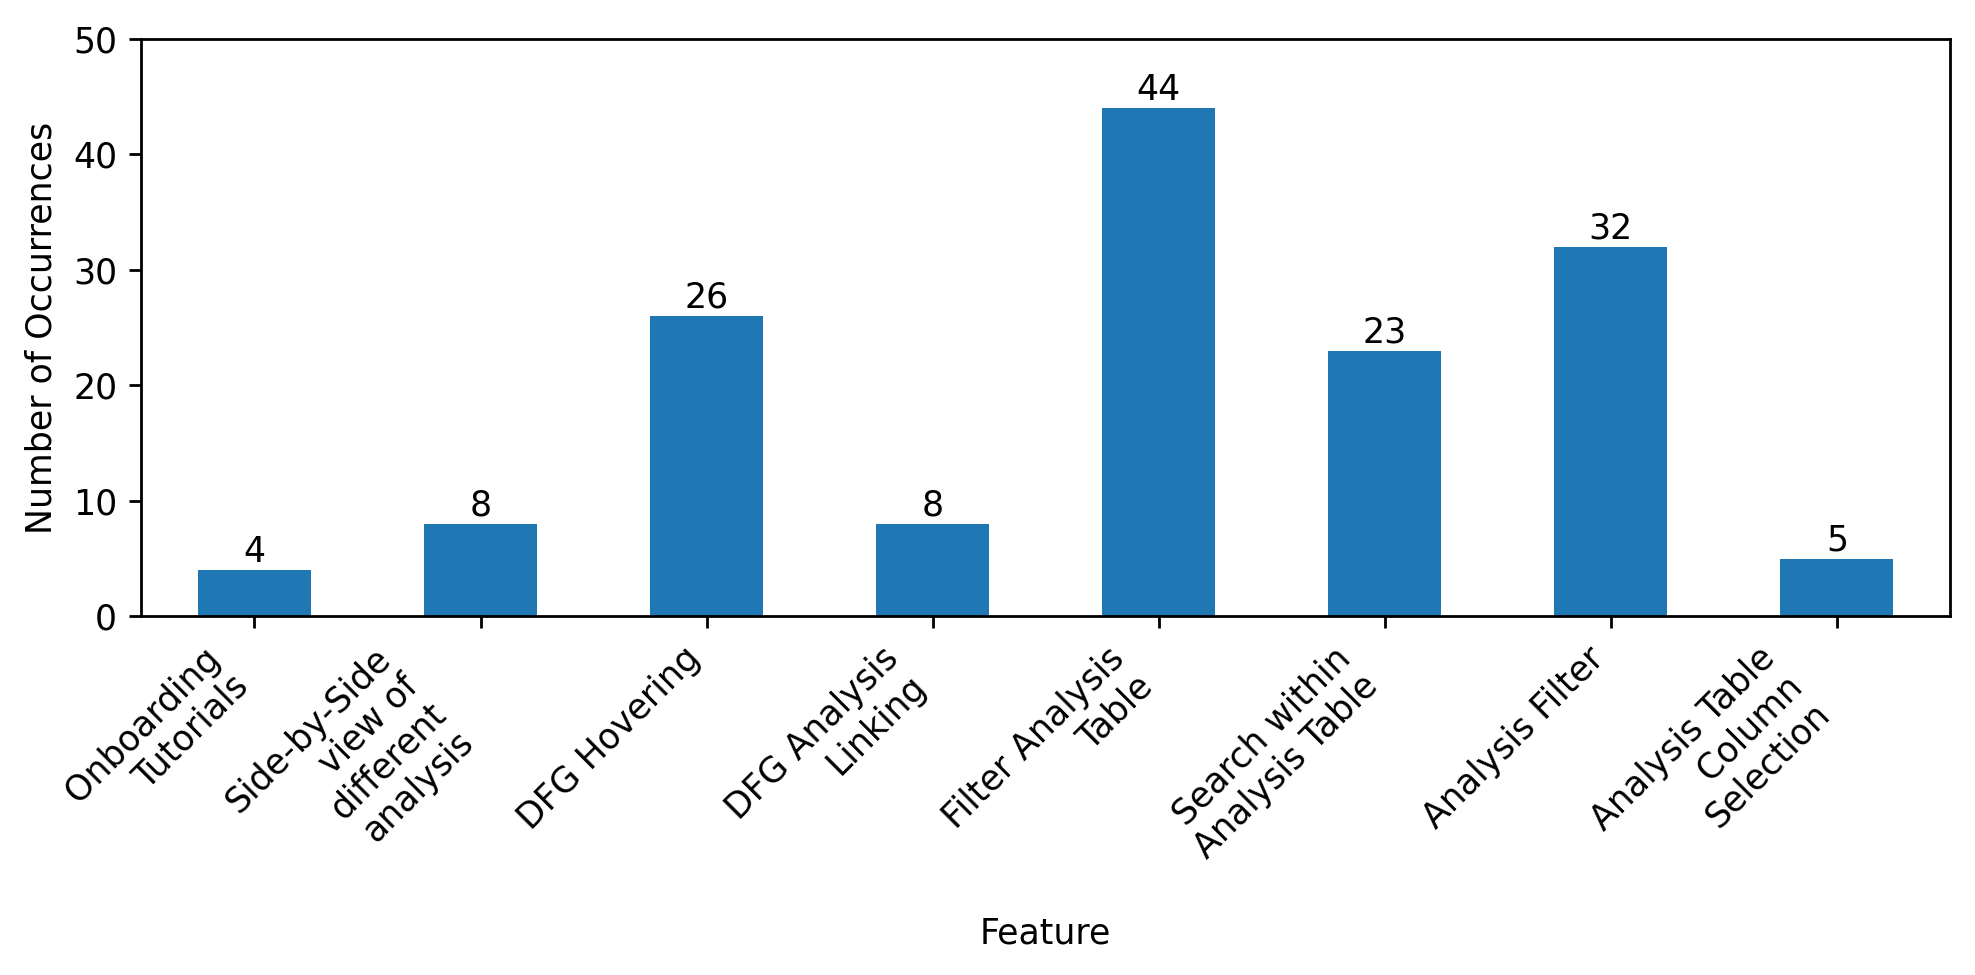

In [9]:
feature_counts = feature_usage_df['Feature'].value_counts().loc[full_feature_list]

# Wrap long feature names
wrapped_labels = ['\n'.join(textwrap.wrap(label, width=15)) for label in full_feature_list]

plt.figure(figsize=(8, 4), dpi=250)
ax = feature_counts.plot(kind='bar')
plt.ylabel('Number of Occurrences')
plt.xlabel('Feature')
ax.set_xticklabels(wrapped_labels, rotation=45, ha='right')

# Add value labels on top of bars
for i, v in enumerate(feature_counts):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom')
plt.yticks(range(0, 51, 10))
plt.tight_layout()
plt.show()

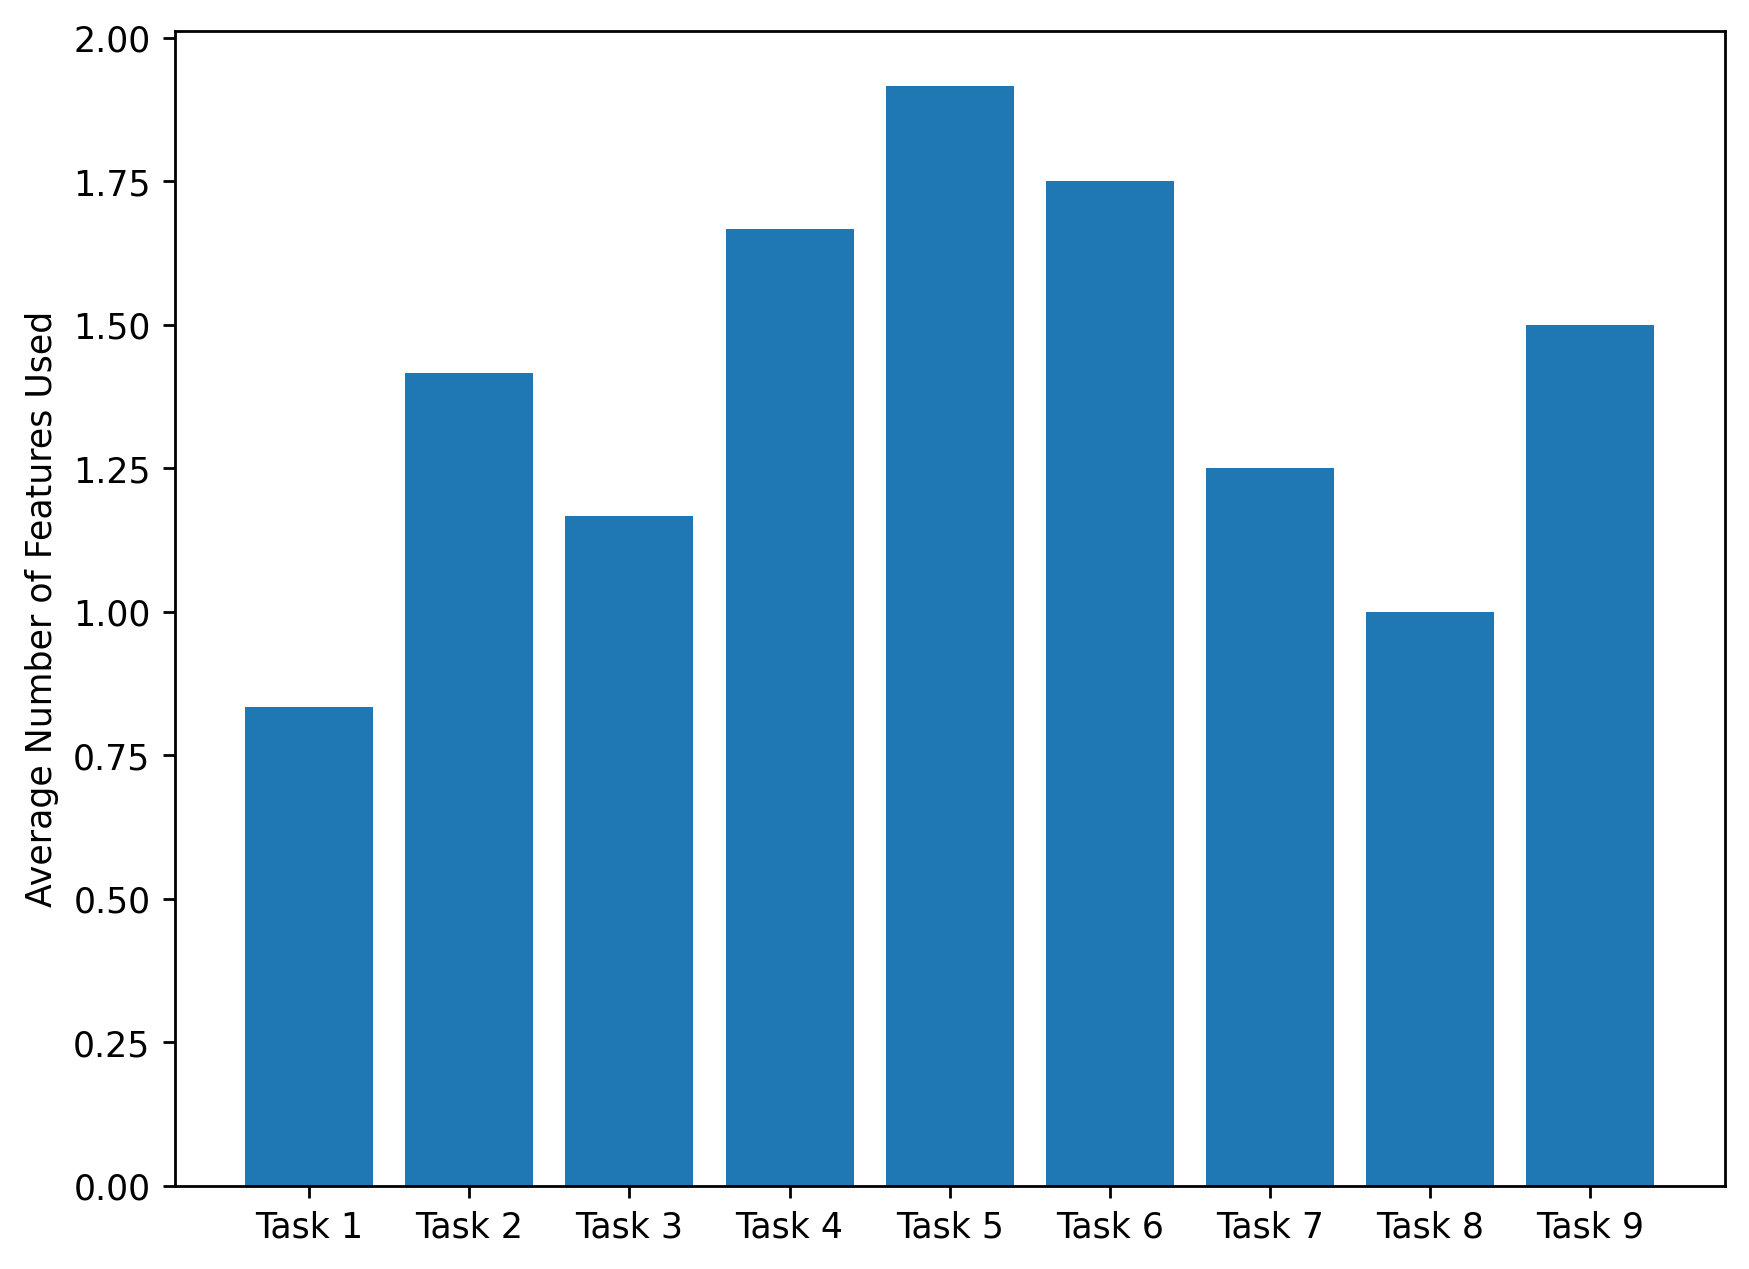

In [10]:
task_labels = [f"Task {i}" for i in range(1, 10)]

features_per_question = []
for col in feature_columns:
    count = 0
    for val in df[col][2:]:  # skip header rows
        if pd.isna(val) or val == '':
            continue
        if isinstance(val, str):
            count += len([f.strip() for f in val.split(',') if f.strip()])
    avg_features = count / number_participants
    features_per_question.append(avg_features)

plt.figure(figsize=(8, 6), dpi=250)
plt.bar(feature_columns, features_per_question)
plt.ylabel('Average Number of Features Used')
plt.xticks(range(len(feature_columns)), task_labels)
plt.show()

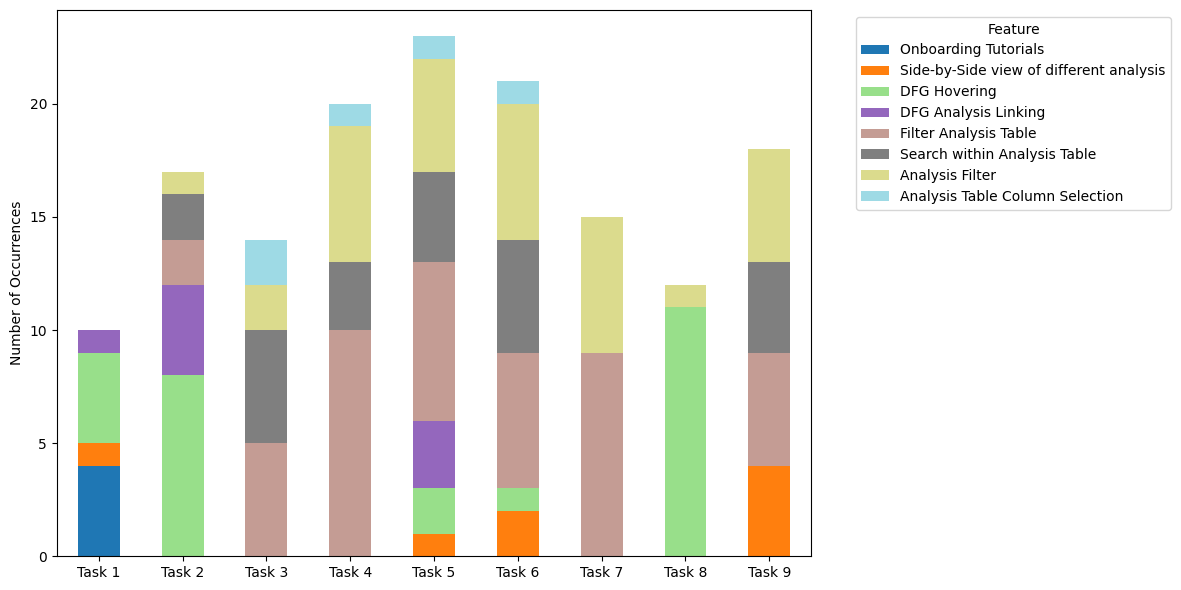

In [28]:
# Create a pivot table: rows=Task, columns=Feature, values=counts
feature_task_counts = feature_usage_df.pivot_table(index='Task', columns='Feature', aggfunc='size', fill_value=0)

# Reorder columns to match full_feature_list
feature_task_counts = feature_task_counts.reindex(columns=full_feature_list, fill_value=0)

plt.figure(figsize=(12, 6))
feature_task_counts.plot(kind='bar', stacked=True, colormap='tab20', ax=plt.gca())
plt.xlabel('')
plt.ylabel('Number of Occurrences')
plt.xticks(ticks=range(len(task_numbers)), labels=task_labels, rotation=0)
plt.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

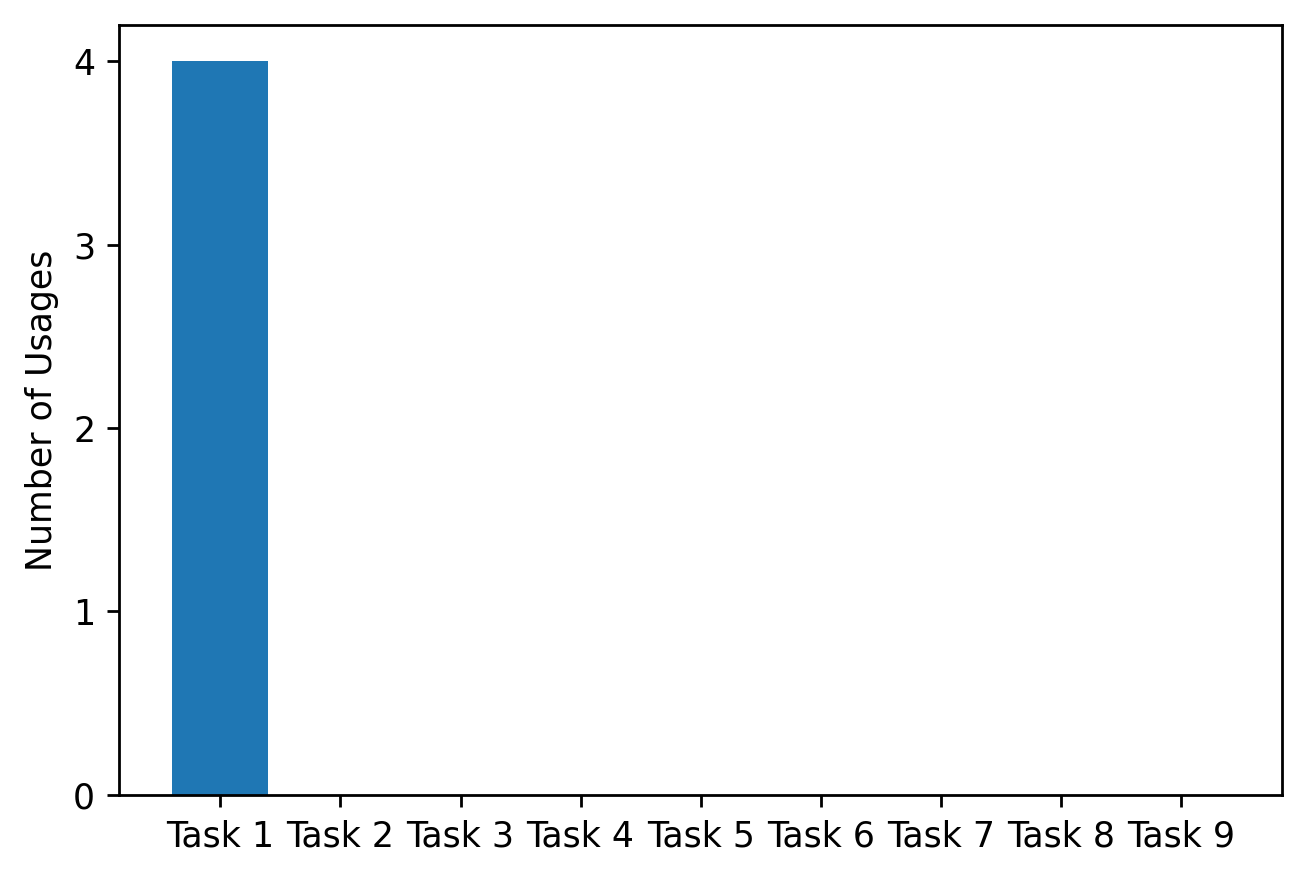

In [12]:
# Find all rows in feature_usage_df where Feature is 'Onboarding Tutorials'
onboarding_df = feature_usage_df[feature_usage_df['Feature'] == 'Onboarding Tutorials']

plt.figure(figsize=(6, 4), dpi=250)
plt.hist(onboarding_df['Task'], bins=range(1, 11), align='left', rwidth=0.8)
plt.ylabel('Number of Usages')
plt.xticks(range(1, 10), [f'Task {i}' for i in range(1, 10)])
plt.yticks(range(0, 5))
plt.show()

### Analysis: Task Accuracy

In [13]:
question_columns = [f'Q{n}' for n in range(23, 32)]

questions_df = df[['ResponseId'] + question_columns].copy()

solution_dictionary = {
    'Q23': '608',
    'Q24': 'Requester',
    'Q25': 'Deliver Goods Services',
    'Q26': '6',
    'Q27': 'R-775',
    'Q28': 'Amend Request for Quotation Requester Manager',
    'Q29': 'R-371,R-753,R-846',
    'Q30': '544',
    'Q31': 'Amend Purchase Requisition'
}

for q in question_columns:
    result_col = f"{q}_result"
    solution = solution_dictionary[q]
    # 1 .. correctly answered, 0 .. incorrectly answered
    questions_df[result_col] = questions_df[q].astype(str).apply(lambda x: 1 if solution in x else 0)

questions_df['test_result'] = questions_df[[f"{q}_result" for q in question_columns]].sum(axis=1)

questions_df = questions_df.iloc[2:].reset_index(drop=True)
questions_df.head(12)

,ResponseId,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q30,Q31,Q23_result,Q24_result,Q25_result,Q26_result,Q27_result,Q28_result,Q29_result,Q30_result,Q31_result,test_result
0,R_2eerRhh5EahoV21,608,Requester,Deliver Goods Services,6,R-297,Release Purchase Order,"R-371,R-753,R-846",544,Amend Purchase Requisition,1,1,1,1,0,0,1,1,1,7
1,R_8qlCxzzpCeA2DOb,608,Requester,Deliver Goods Services,6,R-775,Amend Request for Quotation Requester Manager,"R-371,R-753,R-846",544,Amend Purchase Requisition,1,1,1,1,1,1,1,1,1,9
2,R_8BbOQ4m6bHY4faV,608,Requester,Deliver Goods Services,6,R-297 (Avergage Case duration 8.65),The Resource R-297 performs 7 Activities: Amen...,"R-371,R-753,R-846",544,Amend Purchase Requisition,1,1,1,1,0,0,1,1,1,7
3,R_2syHqA4QObolQbv,608,Couldnt find,Create Quotation comparison Map,4,Request Manager,Idk,"R-371,R-753,R-846",231,Amend Request for Quotation Requester,1,0,0,0,0,0,1,0,0,2
4,R_2djkpenYH4EB7pU,608,Requester,Deliver Goods Services,6,R-775 manager else R-297,Analyze Purchase Requisition,"R-371,R-753,R-846",544,Amend Request for Quotation Requester,1,1,1,1,1,0,1,1,0,7
5,R_8iqvaNLTrBbubFn,413,Requester,Deliver Goods Services,6,R-297,-,"R-371,R-753,R-846",544,Amend Purchase Requisition,0,1,1,1,0,0,1,1,1,6
6,R_2jkC8jcRxnB07b4,608,requester,Deliver Goods Services,6,R-297,Create Request for Quotation Requester,"R-371,R-753,R-846",544,Amend Purchase Requisition,1,0,1,1,0,0,1,1,1,6
7,R_2qxTnkgW6bXZQgM,608,Requester,Deliver Goods Services,6,R-297,Amend Purchase Requisition,"R-371,R-753,R-846",544,Amend Purchase Requisition,1,1,1,1,0,0,1,1,1,7
8,R_8yxWk9DZOFaE25j,608,Requester,Delivery Goods Services,6,R-297,Create Purchase Requisition,"R-371,R-753,R-846",544,Amend Purchase Requisition,1,1,0,1,0,0,1,1,1,6
9,R_2o6bvRyg3OPeAUK,608,Requester,Deliver Goods Services,6,R-297,"R-297 performs 7 tasks at my screen, the longe...","R-371,R-753,R-846",544,Amend Purchase Requisition,1,1,1,1,0,0,1,1,1,7


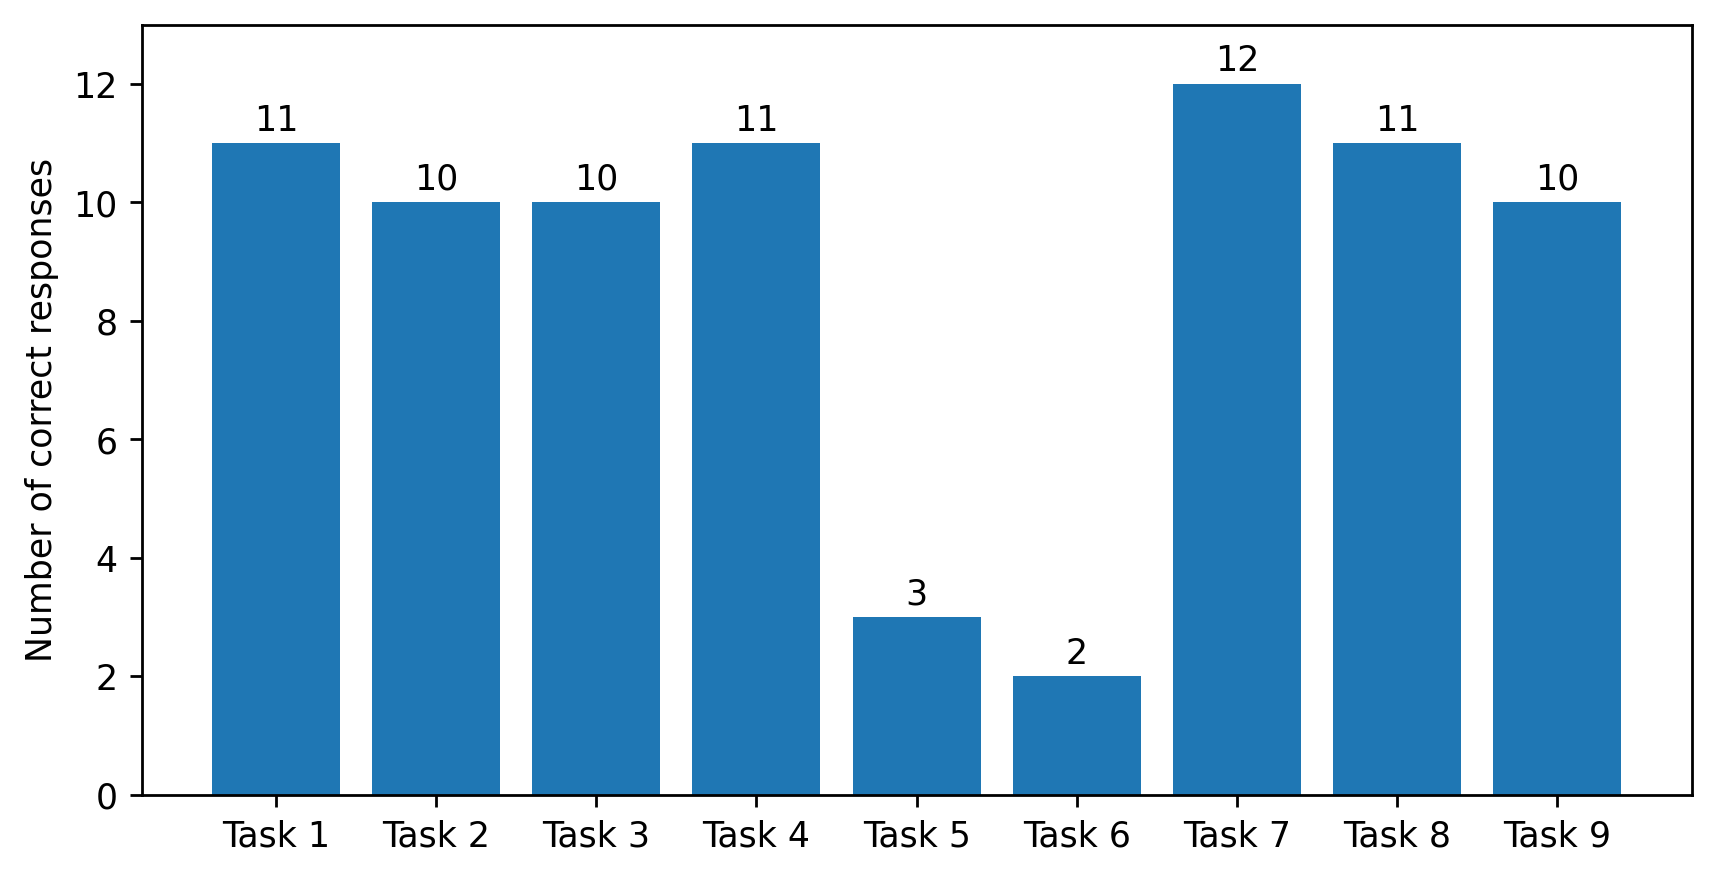

In [14]:
# Count how many participants answered each task correctly
correct_counts = []
for q in question_columns:
    correct = questions_df[f"{q}_result"].sum()
    correct_counts.append(correct)

plt.figure(figsize=(8, 4), dpi=250)
plt.bar(task_labels, correct_counts)
plt.ylabel('Number of correct responses')
plt.ylim(0, number_participants + 1)
for i, v in enumerate(correct_counts):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom')
plt.show()

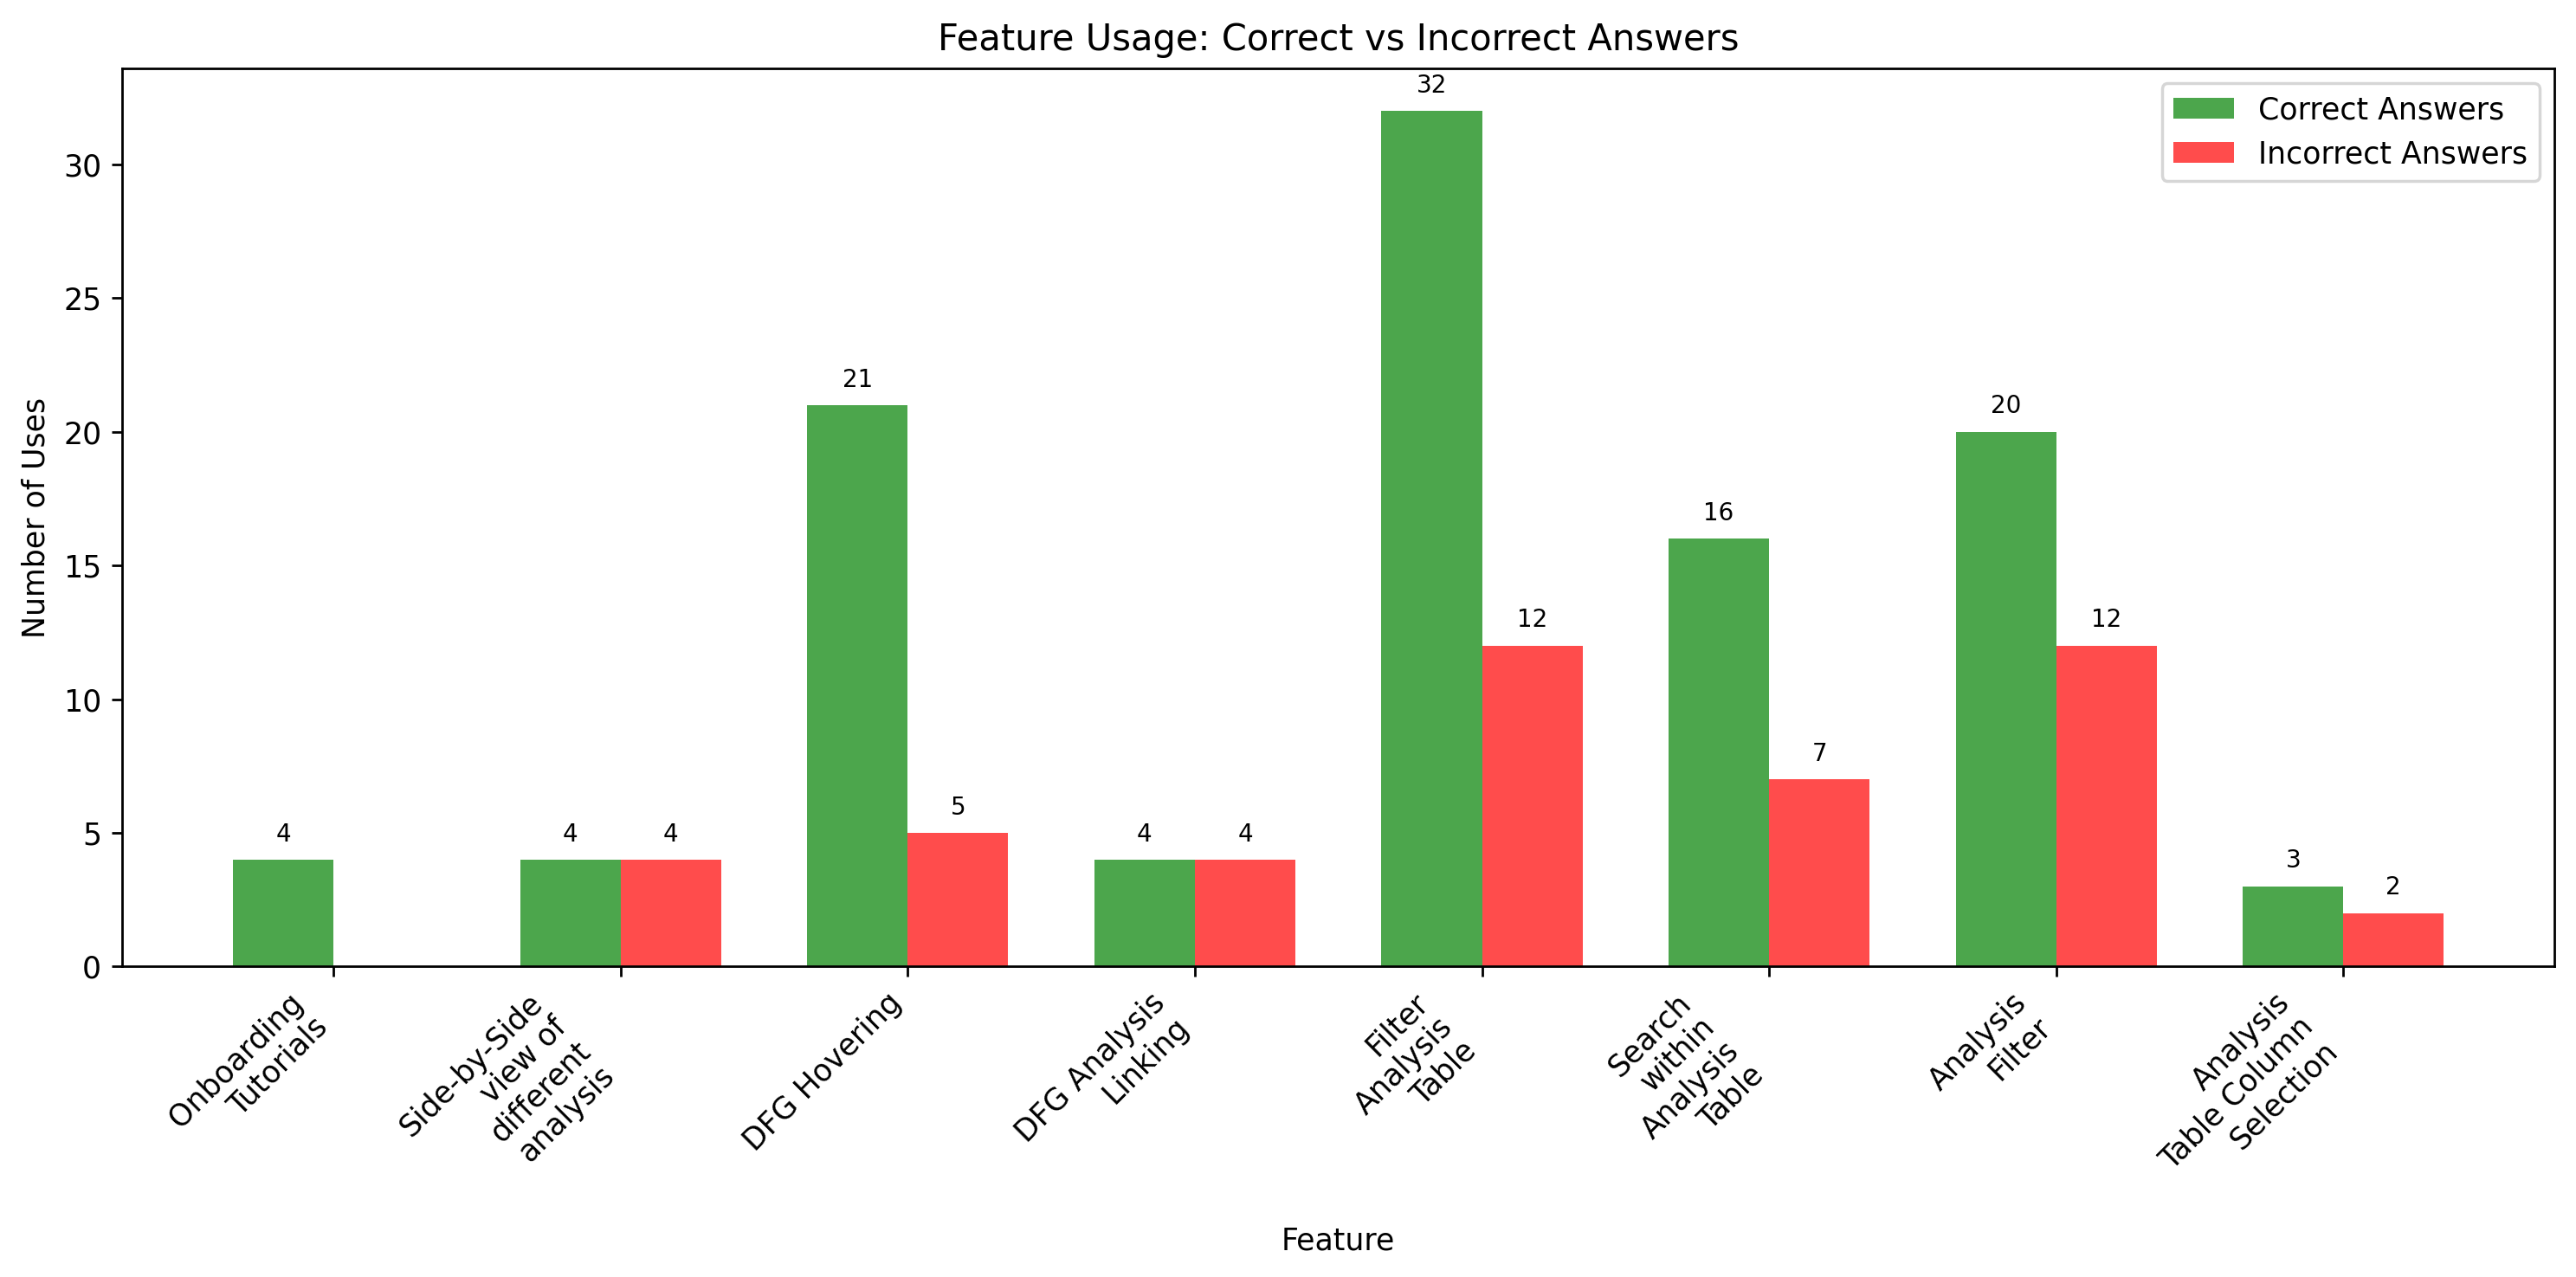

In [32]:
# Create a combined dataframe with feature usage and correctness results
combined_data = []

for index, row in questions_df.iterrows():
    response_id = row['ResponseId']
    
    # Get feature usage for this participant
    participant_features = feature_usage_df[feature_usage_df['ResponseId'] == response_id]
    
    # For each question, check if answered correctly and what features were used
    for i, q in enumerate(question_columns):
        task_num = i + 1
        is_correct = row[f"{q}_result"]
        
        # Get features used for this specific task
        task_features = participant_features[participant_features['Task'] == task_num]['Feature'].tolist()
        
        # Add each feature usage with correctness info
        for feature in task_features:
            combined_data.append({
                'ResponseId': response_id,
                'Task': task_num,
                'Feature': feature,
                'Correct': is_correct
            })

combined_df = pd.DataFrame(combined_data)

# Calculate feature usage for correct vs incorrect answers
correct_features = combined_df[combined_df['Correct'] == 1]['Feature'].value_counts()
incorrect_features = combined_df[combined_df['Correct'] == 0]['Feature'].value_counts()

# Ensure all features are represented (fill missing with 0)
all_features = full_feature_list
correct_counts = [correct_features.get(f, 0) for f in all_features]
incorrect_counts = [incorrect_features.get(f, 0) for f in all_features]

# Create the plot
plt.figure(figsize=(12, 6), dpi=250)
x = range(len(all_features))
width = 0.35

plt.bar([i - width/2 for i in x], correct_counts, width, label='Correct Answers', color='green', alpha=0.7)
plt.bar([i + width/2 for i in x], incorrect_counts, width, label='Incorrect Answers', color='red', alpha=0.7)

# Wrap long feature names
wrapped_labels = ['\n'.join(textwrap.wrap(label, width=12)) for label in all_features]
plt.xlabel('Feature')
plt.ylabel('Number of Uses')
plt.title('Feature Usage: Correct vs Incorrect Answers')
plt.xticks(x, wrapped_labels, rotation=45, ha='right')
plt.legend()

# Add value labels on bars
for i, (correct, incorrect) in enumerate(zip(correct_counts, incorrect_counts)):
    if correct > 0:
        plt.text(i - width/2, correct + 0.5, str(correct), ha='center', va='bottom', fontsize=8)
    if incorrect > 0:
        plt.text(i + width/2, incorrect + 0.5, str(incorrect), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
onboarding_response_ids = feature_usage_df[feature_usage_df['Feature'] == 'Onboarding Tutorials']['ResponseId'].tolist()

# Split questions_df into two groups
onboarding_group_df = questions_df[questions_df['ResponseId'].isin(onboarding_response_ids)]
no_onboarding_group_df = questions_df[~questions_df['ResponseId'].isin(onboarding_response_ids)]

# Get the test results for each group
onboarding_scores = onboarding_group_df['test_result']
no_onboarding_scores = no_onboarding_group_df['test_result']

# Calculate descriptive statistics
onboarding_avg = onboarding_scores.mean()
no_onboarding_avg = no_onboarding_scores.mean()
onboarding_median = onboarding_scores.median()
no_onboarding_median = no_onboarding_scores.median()

print(f"Participants who used onboarding tutorials:")
print(f"  Count: {len(onboarding_group_df)}")
print(f"  Average test result: {onboarding_avg:.2f}")
print(f"  Median test result: {onboarding_median:.2f}")

print(f"\nParticipants who did NOT use onboarding tutorials:")
print(f"  Count: {len(no_onboarding_group_df)}")
print(f"  Average test result: {no_onboarding_avg:.2f}")
print(f"  Median test result: {no_onboarding_median:.2f}")

print(f"\nDifference in means: {onboarding_avg - no_onboarding_avg:.2f}")
print(f"Difference in medians: {onboarding_median - no_onboarding_median:.2f}")

# Mann-Whitney U test (non-parametric test for small samples)
mannwhitney_stat, mannwhitney_p = stats.mannwhitneyu(
    onboarding_scores, 
    no_onboarding_scores, 
    alternative='two-sided'
)

print(f"\nMann-Whitney U Test:")
print(f"  U-statistic: {mannwhitney_stat:.4f}")
print(f"  p-value: {mannwhitney_p:.4f}")

# Interpretation
alpha = 0.05
if mannwhitney_p < alpha:
    print(f"\nResult: Significant difference found (p < {alpha})")
    if onboarding_median > no_onboarding_median:
        print("Participants who used onboarding tutorials performed significantly better.")
    else:
        print("Participants who did NOT use onboarding tutorials performed significantly better.")
else:
    print(f"\nResult: No significant difference found (p >= {alpha})")
    print("There is no statistically significant difference between the two groups.")

Participants who used onboarding tutorials:
  Count: 4
  Average test result: 6.00
  Median test result: 6.50

Participants who did NOT use onboarding tutorials:
  Count: 8
  Average test result: 7.00
  Median test result: 7.00

Difference in means: -1.00
Difference in medians: -0.50

Mann-Whitney U Test:
  U-statistic: 13.0000
  p-value: 0.6471

Result: No significant difference found (p >= 0.05)
There is no statistically significant difference between the two groups.


### Analysis: User Satisfaction

/var/folders/km/t7hmprw54tx94r_7vptkgzr00000gn/T/ipykernel_1855/1224792012.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, vert=False, labels=[f"U{i}" for i in range(1, 13)])


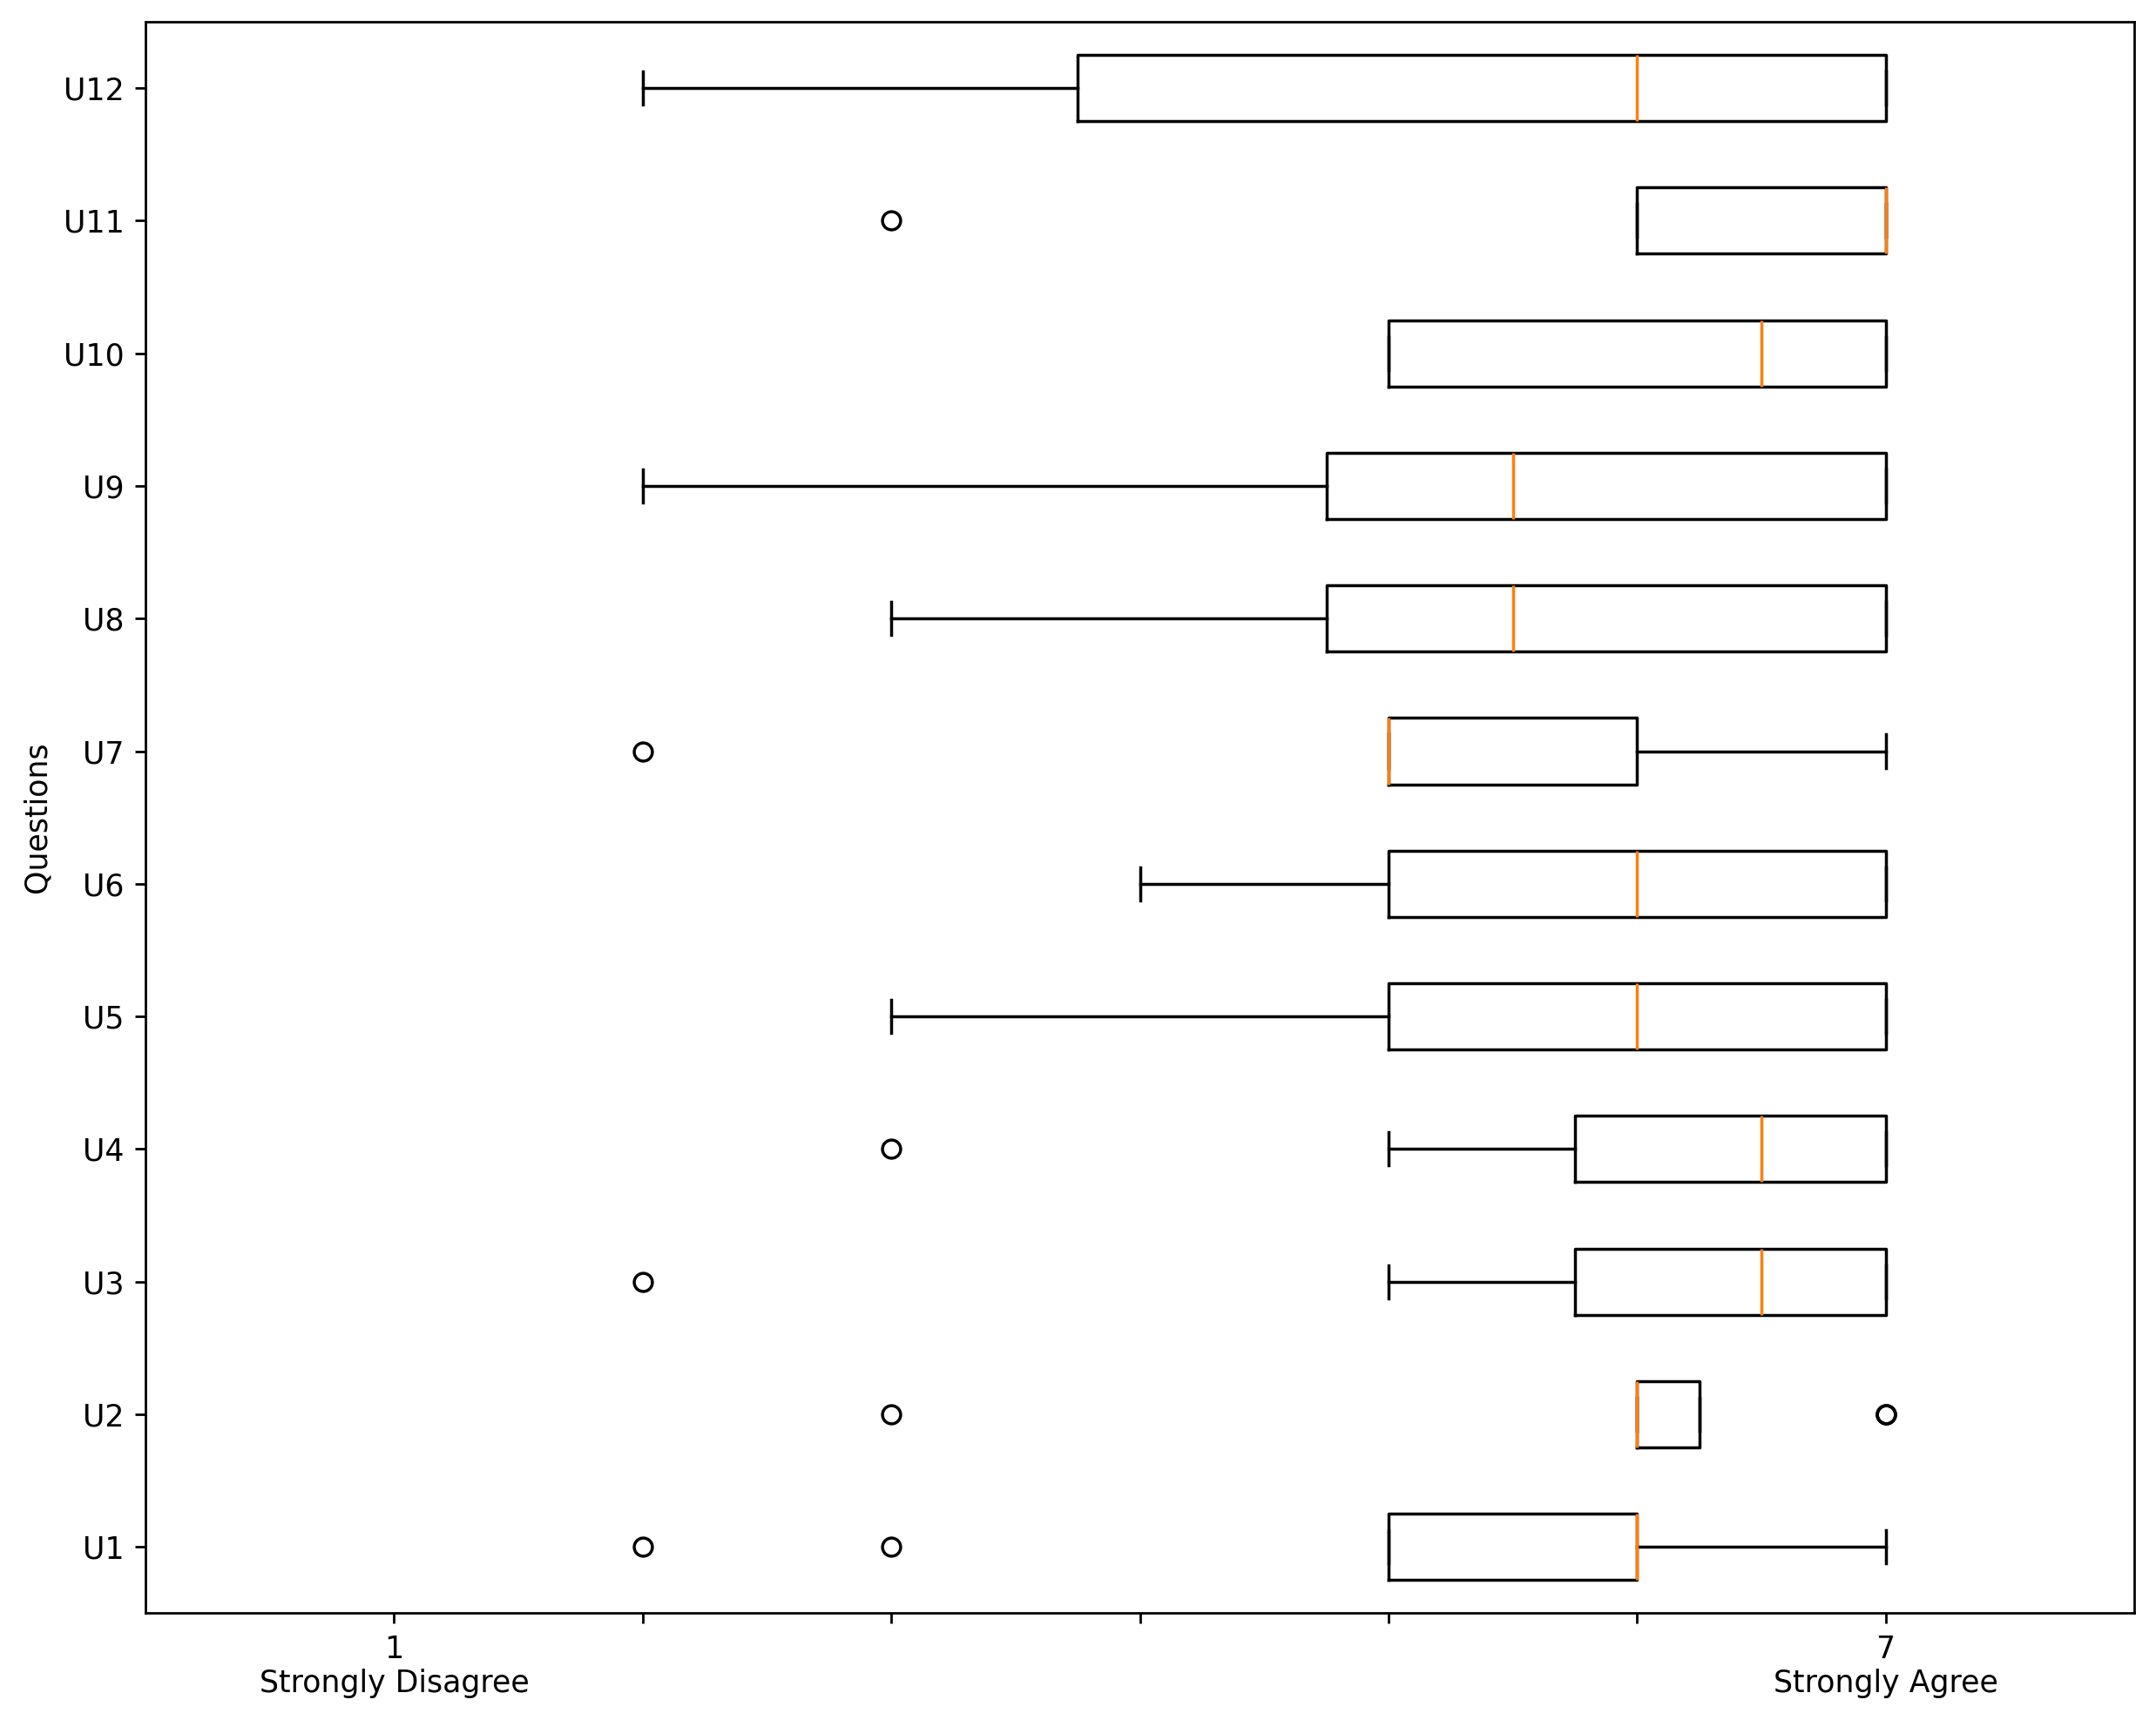

In [17]:
plt.figure(figsize=(10, 8), dpi=250)
data_to_plot = [df[f"U{i}"].iloc[2:].astype(float).dropna() for i in range(1, 13)]
plt.boxplot(data_to_plot, vert=False, labels=[f"U{i}" for i in range(1, 13)])
plt.ylabel('Questions')
plt.xlim(0, 8)
plt.xticks([1, 2, 3, 4, 5, 6, 7], ['1\nStrongly Disagree', '', '', '', '', '', '7\nStrongly Agree'])
plt.tight_layout()
plt.show()

User satisfaction (U2) vs Test results:
           ResponseId   U2  test_result
0   R_2eerRhh5EahoV21  6.0            7
1   R_8qlCxzzpCeA2DOb  7.0            9
2   R_8BbOQ4m6bHY4faV  6.0            7
3   R_2syHqA4QObolQbv  3.0            2
4   R_2djkpenYH4EB7pU  6.0            7
5   R_8iqvaNLTrBbubFn  6.0            6
6   R_2jkC8jcRxnB07b4  6.0            6
7   R_2qxTnkgW6bXZQgM  7.0            7
8   R_8yxWk9DZOFaE25j  6.0            6
9   R_2o6bvRyg3OPeAUK  6.0            7
10  R_2ONNAClCAm2UURX  7.0            9
11  R_8ePBBrk9aTmUe6B  6.0            7

Correlation between user satisfaction (U2) and test results: 0.9316


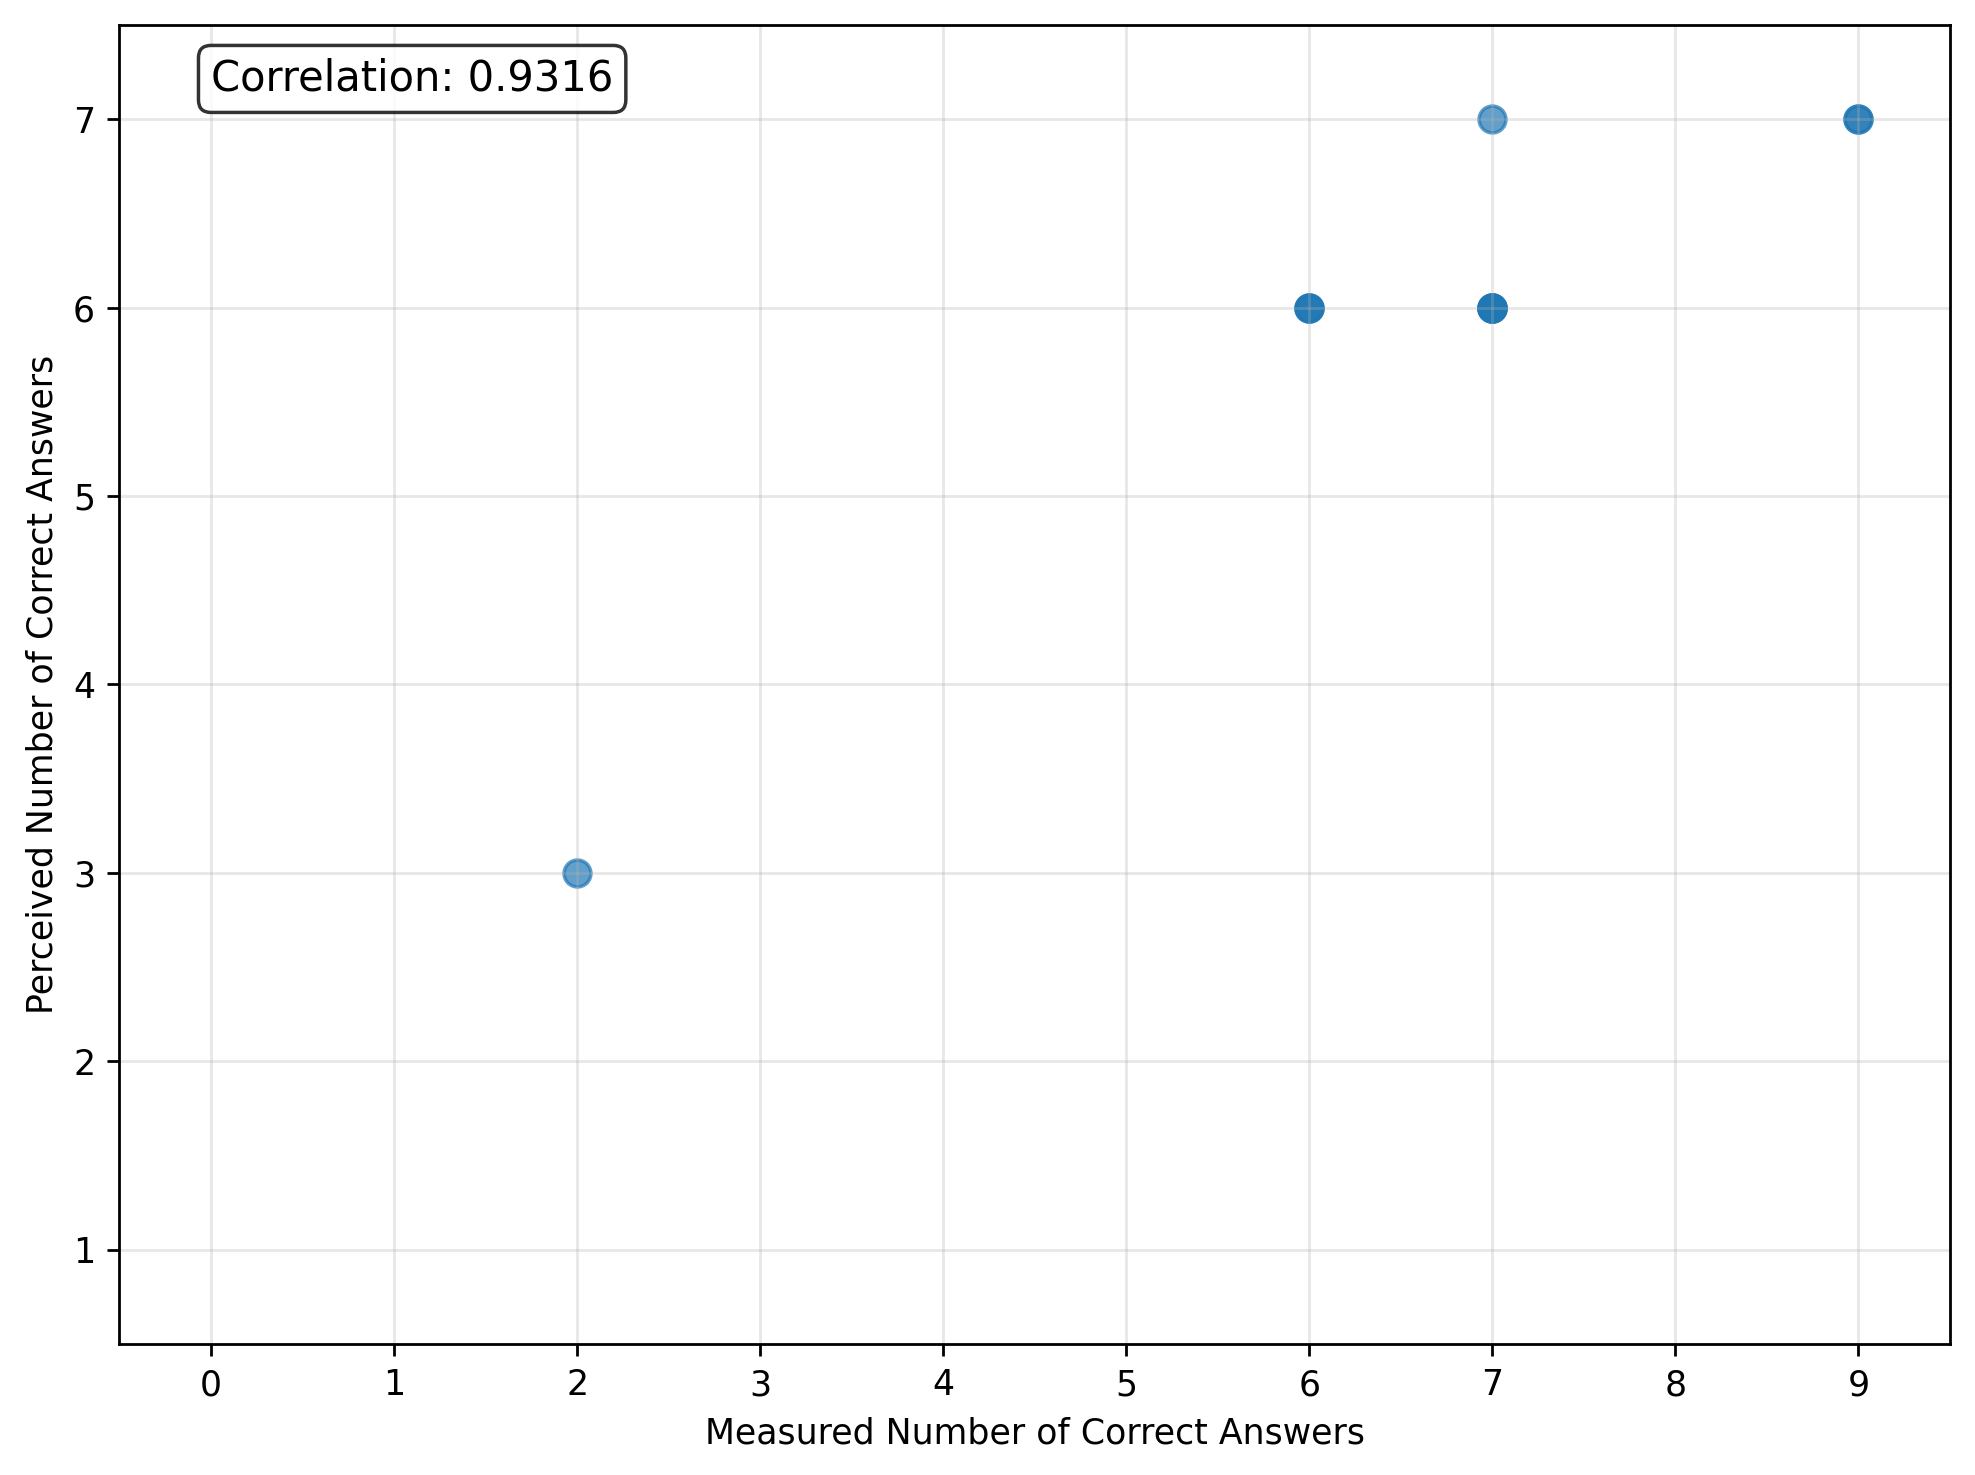


Analysis by satisfaction levels:
Satisfaction 3.0: 1 participants, avg test score: 2.00
Satisfaction 6.0: 8 participants, avg test score: 6.62
Satisfaction 7.0: 3 participants, avg test score: 8.33


In [31]:
u2_correct_df = df[['ResponseId', 'U2']].iloc[2:].copy()
u2_correct_df['U2'] = u2_correct_df['U2'].astype(float)

# Merge with questions_df to get test_result
u2_correct_df = u2_correct_df.merge(
    questions_df[['ResponseId', 'test_result']],
    on='ResponseId',
    how='inner'
)

print("User satisfaction (U2) vs Test results:")
print(u2_correct_df)

# Calculate correlation
correlation = u2_correct_df['U2'].corr(u2_correct_df['test_result'])
print(f"\nCorrelation between user satisfaction (U2) and test results: {correlation:.4f}")

# Create scatter plot
plt.figure(figsize=(8, 6), dpi=250)
plt.scatter(u2_correct_df['test_result'], u2_correct_df['U2'], alpha=0.7, s=60)
plt.xlabel('Measured Number of Correct Answers')
plt.ylabel('Perceived Number of Correct Answers')
plt.xlim(-0.5, 9.5)
plt.ylim(0.5, 7.5)
plt.xticks(range(0, 10))
plt.yticks(range(1, 8))
plt.grid(True, alpha=0.3)

# Add correlation coefficient to plot
plt.text(0.05, 0.95, f'Correlation: {correlation:.4f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Additional analysis: group by satisfaction levels
print("\nAnalysis by satisfaction levels:")
for satisfaction in sorted(u2_correct_df['U2'].unique()):
    subset = u2_correct_df[u2_correct_df['U2'] == satisfaction]
    avg_score = subset['test_result'].mean()
    print(f"Satisfaction {satisfaction}: {len(subset)} participants, avg test score: {avg_score:.2f}")

### Analysis: Participant Demographics

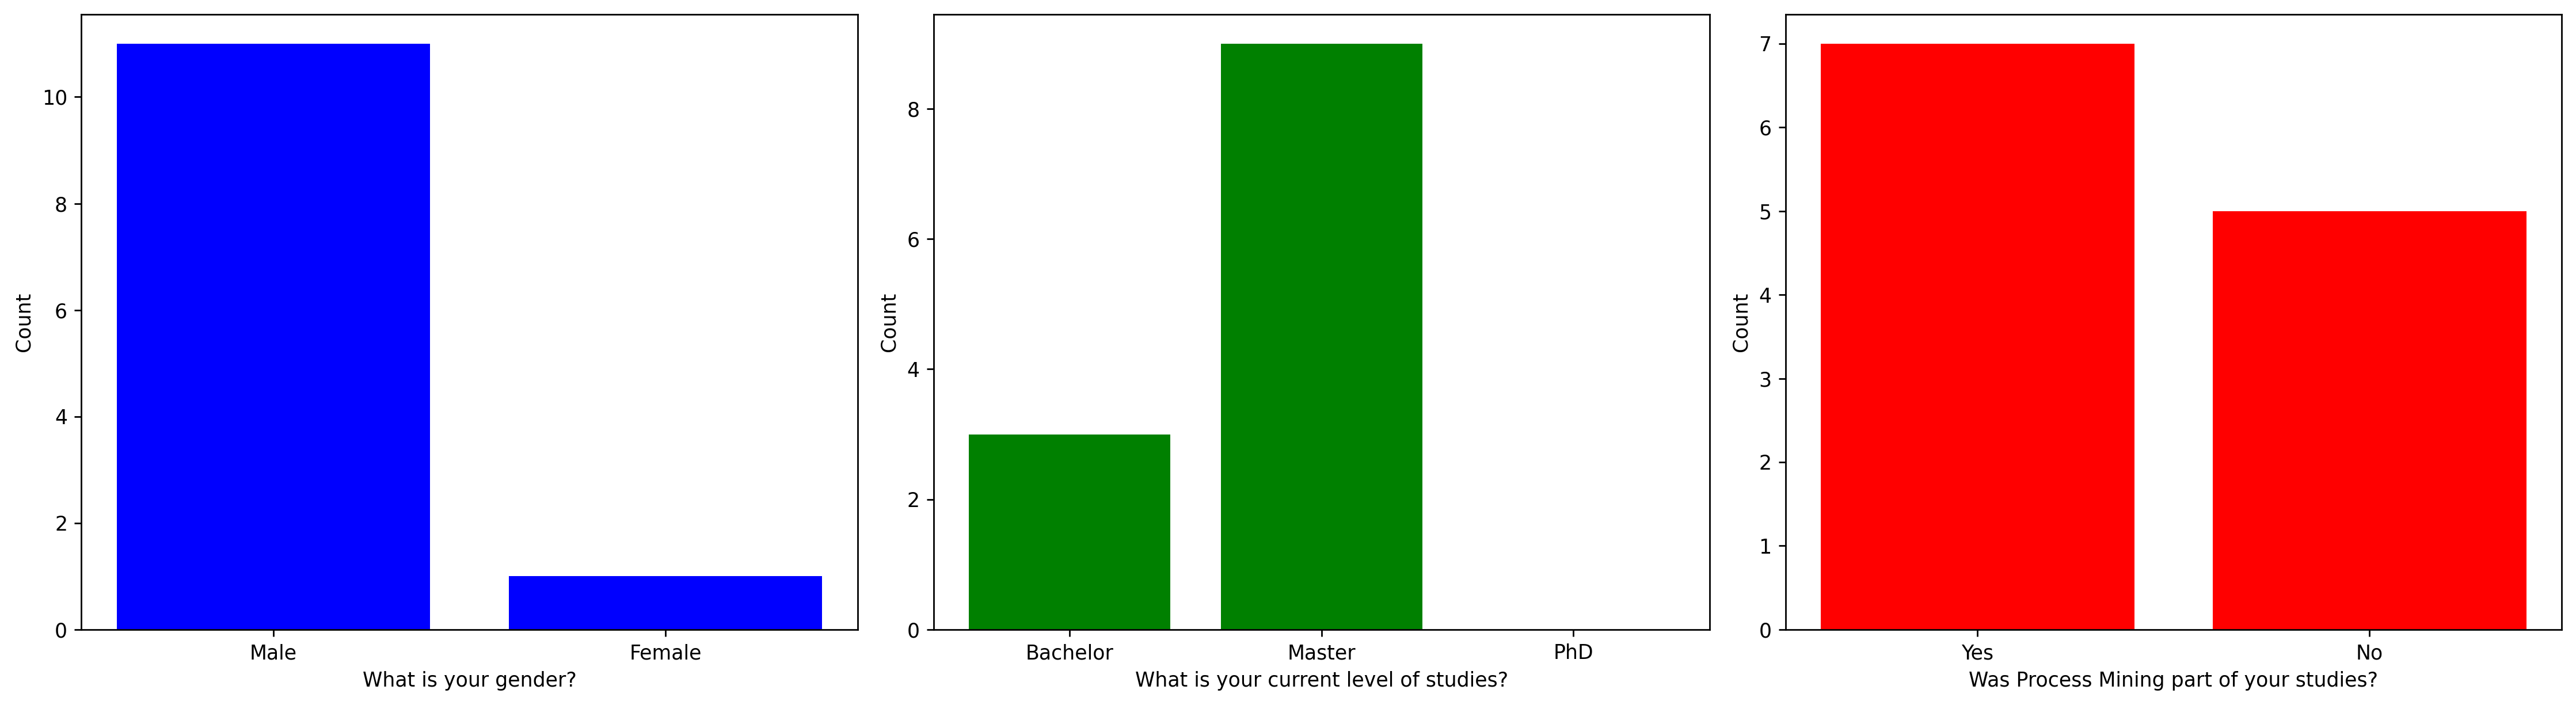

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=250)

# Q13: Gender
df_q13 = df['Q13'].iloc[2:]
gender_counts = df_q13.value_counts()
axes[0].bar(gender_counts.index, gender_counts.values, color='blue')
axes[0].set_xlabel('What is your gender?')
axes[0].set_ylabel('Count')

# Q14: Level of studies
df_q14 = df['Q14'].iloc[2:]
study_counts = df_q14.value_counts()

# Add PhD with 0 count if not present
all_study_levels = ['Bachelor', 'Master', 'PhD']
study_counts_complete = pd.Series([study_counts.get(level, 0) for level in all_study_levels], index=all_study_levels)

axes[1].bar(study_counts_complete.index, study_counts_complete.values, color='green')
axes[1].set_xlabel('What is your current level of studies?')
axes[1].set_ylabel('Count')

# Q15: Learned about process mining
df_q15 = df['Q15'].iloc[2:]
pm_counts = df_q15.value_counts()
axes[2].bar(pm_counts.index, pm_counts.values, color='red')
axes[2].set_xlabel('Was Process Mining part of your studies?')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()